# Projet 6 - Classez des images à l'aide d'algorithmes de Deep Learning

## Espace de bibliothèques

In [6]:
from PIL import Image
import pandas as pd
import numpy as np

import time
import os
import shutil
import tarfile
import requests
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras.preprocessing.image
from tensorboard import notebook
import glob
from skimage import io
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow
import datetime
from keras.preprocessing import image
from keras.utils import load_img,img_to_array, array_to_img
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
    
from functools import partial
from livelossplot import PlotLossesKeras

## Espace de fonctions

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-10-08 15:55:01.520878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 15:55:01.554167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 15:55:01.554271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5021434476405212209
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6122962944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15094119886970008554
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2022-10-08 15:55:18.803672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-08 15:55:18.804175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 15:55:18.804309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 15:55:18.804380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

In [10]:
gpu_available = tf.test.is_gpu_available()
gpu_available

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-10-08 15:55:28.989286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 15:55:28.989433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 15:55:28.989501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 15:55:28.989610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 15:55:28.989681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

True

839 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6


##### Fonction qui nous sert à visualiser l'augmentation des images

In [11]:
def vis_datagen(datagen,n):
    path_dog_family = os.path.join(train_path, "n02099712-Labrador_retriever")
    fnames = [os.path.join(path_dog_family, fname) for fname in os.listdir(path_dog_family)]

    img_path = fnames[n]
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    augmented = []

    i = 0
    for batch in datagen.flow(x, batch_size = 1):
        plt.figure(i)
        augmented.append(array_to_img(batch[0]))
        i += 1
        if i % 3 == 0:
            break

    fig = plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.title('Original')
    plt.imshow(img)

    for i in range(3):
        plt.subplot(1,4,i+2)
        plt.title(f'Augmented {i+1}')
        plt.imshow(augmented[i])

## Chargement & répartition des données

In [12]:
%%time

#Déclaration des chemins dans lesquels on stocke nos fichiers d'apprentissage, de validation et de test
directory = os.getcwd()
images = os.path.join(directory, "Images")
data = os.path.join(directory, "data")

train_path = os.path.join(data, "train")
os.makedirs(train_path, exist_ok=True)

val_path = os.path.join(data, "val")
os.makedirs(val_path, exist_ok=True)

test_path = os.path.join(data, "test")
os.makedirs(test_path, exist_ok=True)

#Seuil des remplissages
val_threshold = 0.75
test_threshold = val_threshold + 0.15

#Métrique de vérifications
train_size = 0
val_size = 0
test_size = 0
num_classes = 0

#Boucle de remplissage de dossiers
for breed_dir in os.listdir(images):
  num_classes += 1

  breed_dir_path = os.path.join(images, breed_dir)
  breed_train_path = os.path.join(train_path, breed_dir)
  breed_val_path = os.path.join(val_path, breed_dir)
  breed_test_path = os.path.join(test_path, breed_dir)

  os.makedirs(breed_train_path, exist_ok=True)
  os.makedirs(breed_val_path, exist_ok=True)
  os.makedirs(breed_test_path, exist_ok=True)
    
  breed_list = os.listdir(breed_dir_path)
  breed_size = len(breed_list)
  breed_val_threshold = math.ceil(breed_size *  val_threshold)
  breed_test_threshold = math.ceil(breed_size * test_threshold)

  breed_train_range = breed_list[:breed_val_threshold]
  breed_val_range = breed_list[breed_val_threshold:breed_test_threshold]
  breed_test_range = breed_list[breed_test_threshold:breed_size]

  try:
    assert len(breed_train_range) + len(breed_val_range) + len(breed_test_range) == breed_size
  except AssertionError :
    print("Toutes les photos de la race ne sont pas prise en compte")
    print(f"Pour la race {breed_dir}")
    break

  for i, image in enumerate(breed_train_range):
    src = os.path.join(breed_dir_path, image)
    dest = os.path.join(breed_train_path, image)
    shutil.copyfile(src, dest)
    train_size += 1

  for _, image in enumerate(breed_val_range):
    src = os.path.join(breed_dir_path, image)
    dest = os.path.join(breed_val_path, image)
    shutil.copyfile(src, dest)
    val_size +=1

  for _, image in enumerate(breed_test_range):
    src = os.path.join(breed_dir_path, image)
    dest = os.path.join(breed_test_path, image)
    shutil.copyfile(src, dest)
    test_size +=1
  
print("... Data split done ...")
print(f"Nombre de classes: {num_classes}")
print(f"train set size: {train_size}")
print(f"val set size: {val_size}")
print(f"test set size: {test_size}")

... Data split done ...
Nombre de classes: 120
train set size: 15480
val set size: 3091
test set size: 2009
CPU times: user 326 ms, sys: 996 ms, total: 1.32 s
Wall time: 3.67 s


# I - Pré-traitement des images

## Chargement des images

In [13]:
img_size = (224,224)

## Ouverture conseillée par Keras (lien keras à mettre)
train_generator = image_dataset_from_directory(train_path,
                                              image_size=img_size,
                                              batch_size=32,
                                              seed=1337)#,
                                              #label_mode = "categorical")
val_generator = image_dataset_from_directory(val_path,
                                             image_size=img_size,
                                             batch_size=32,
                                             seed=1337)#,
                                            #label_mode = "categorical")

Found 15480 files belonging to 120 classes.
Found 3091 files belonging to 120 classes.


2022-10-08 15:55:51.296132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 15:55:51.296268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 15:55:51.296337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 15:55:51.296438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 15:55:51.296508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

### Visualisation des données

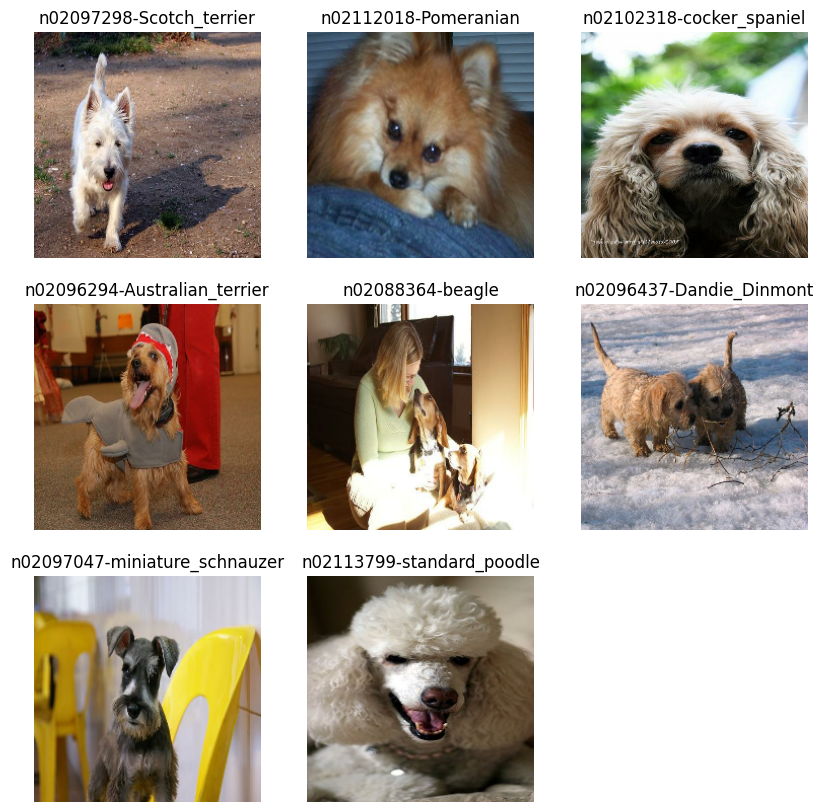

In [14]:
class_names = train_generator.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_generator.take(1):
    for i in range(8):
        #print(i)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
train_generator=train_generator.prefetch(buffer_size=32)
val_generator = val_generator.prefetch(buffer_size=32)

### I.1 - Whitening

In [8]:
x_train, y_train = tuple(zip(*train_generator))
x_val, y_val = tuple(zip(*val_generator))

In [6]:
datagen = ImageDataGenerator(zca_whitening=True)

/home/fayz/Documents/OpenClassrooms/Projet6/p6/lib/python3.10/site-packages/keras/preprocessing/image.py:1285: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [9]:
datagen.fit(x_train[0])

MemoryError: Unable to allocate 84.4 GiB for an array with shape (150528, 150528) and data type float32

#### Impossible d'effectuer le whitening sur nos données, allocation de 84.4Go de données demandées

### I.2 - Rescaling - Random Rotation - Vertical flip - Centered & Normalized pictures

#### Création d'un nouveau générateur de données

In [18]:
datagen = ImageDataGenerator(rescale=1./255,
                             featurewise_center=True, 
                             featurewise_std_normalization=True, 
                             vertical_flip=True,
                             rotation_range=90)

In [19]:
for i in range(len(x_train)):
    datagen.fit(x_train[i])

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

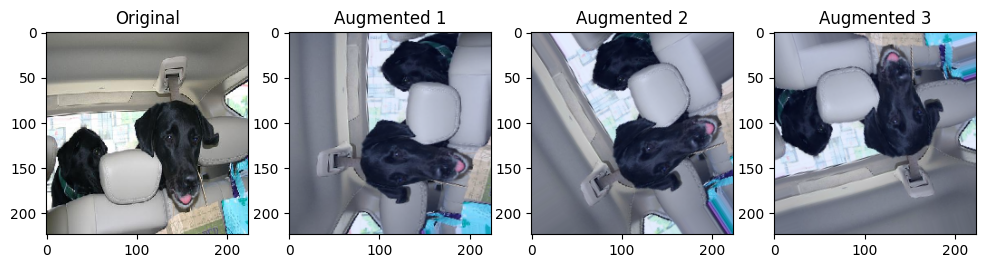

In [20]:
vis_datagen(datagen,1)

In [12]:
train_generator = datagen.flow_from_directory(train_path,
                                              target_size=img_size,
                                              batch_size=32,
                                              class_mode="categorical")

val_generator = datagen.flow_from_directory(val_path,
                                          target_size=img_size,
                                          batch_size=32,
                                          class_mode='categorical')

Found 15480 images belonging to 120 classes.
Found 3091 images belonging to 120 classes.


# II - Création des modèles d'apprentissage

### II-1 CNN

#### Premier modèle

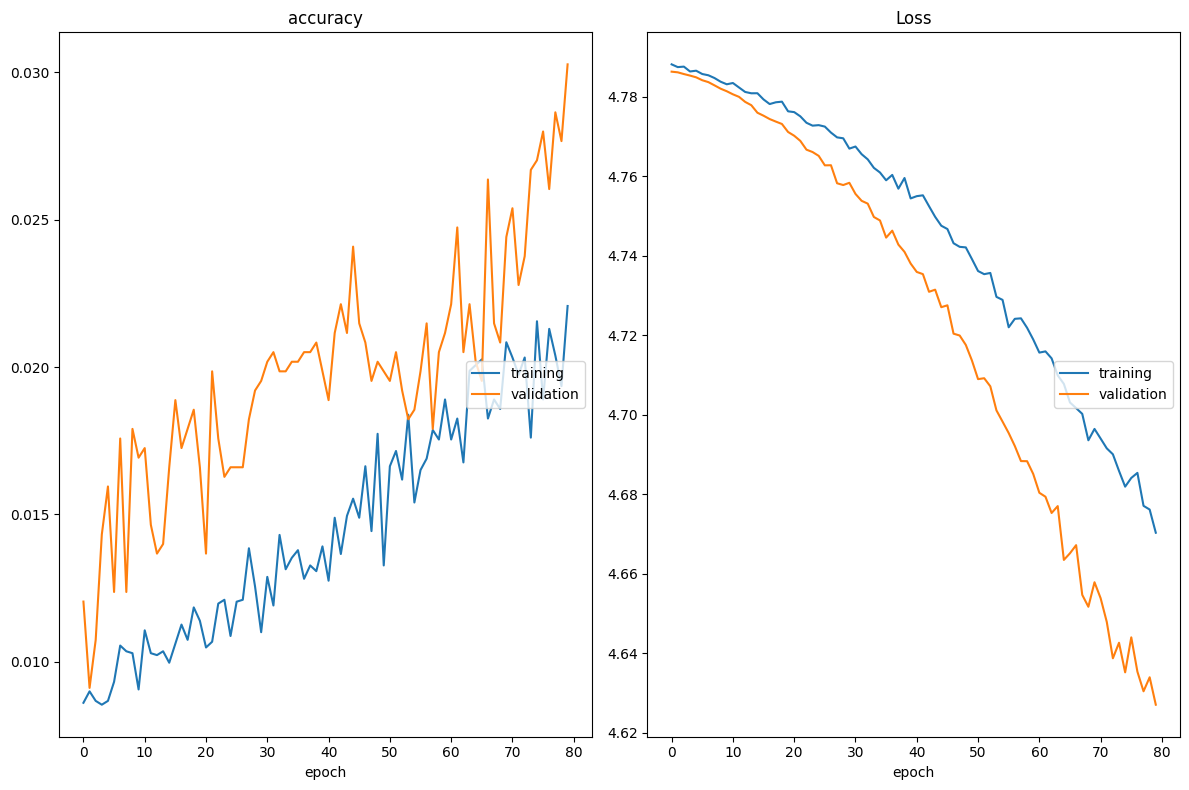

accuracy
	training         	 (min:    0.009, max:    0.022, cur:    0.022)
	validation       	 (min:    0.009, max:    0.030, cur:    0.030)
Loss
	training         	 (min:    4.670, max:    4.788, cur:    4.670)
	validation       	 (min:    4.627, max:    4.786, cur:    4.627)
483/483 [==============================] - 57s 118ms/step - loss: 4.6703 - accuracy: 0.0221 - val_loss: 4.6270 - val_accuracy: 0.0303
CPU times: user 1h 4min 36s, sys: 1min 3s, total: 1h 5min 40s
Wall time: 1h 15min 42s


In [23]:
%%time
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[128, 128, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=num_classes, activation='softmax'),
])
models_path = os.path.join(directory, "models")
os.makedirs(models_path, exist_ok=True)
file_path = models_path + "/my_vgg_model.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')
plot_loss_cb = PlotLossesKeras()

batch_size = 32
epochs = 80

model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"],
              run_eagerly=True)

model.fit(train_generator,
          steps_per_epoch = train_size // batch_size,
          epochs=epochs,
          validation_data=val_generator,
          validation_steps = val_size // batch_size,
          callbacks=[checkpoint_cb, plot_loss_cb])

### Le modèl n'a pas réussi à apprendre. Il se peut que l'architecture du modèl ne soit pas adapté au problème. Nous allons donc reconstruire un modèl qui est adapté à la problématique

### II-2 Entrainement VGG16 réconstitué

In [19]:
def create_generator(path, size):
    generator = image_dataset_from_directory(path,
                                            image_size=size,
                                            batch_size=32,
                                            seed=1337)#,
                                            #label_mode = "categorical")
    return generator

In [20]:
img_size = (224,224)
train_generator = create_generator(train_path,img_size)
val_generator = create_generator(val_path, img_size)

Found 15480 files belonging to 120 classes.
Found 3091 files belonging to 120 classes.


In [21]:
x_train, y_train = tuple(zip(*train_generator))
x_val, y_val = tuple(zip(*val_generator))   
    
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255,
                             featurewise_center=True, 
                             featurewise_std_normalization=True,
                             vertical_flip=True,
                             rotation_range=90)

In [22]:
for i in range(len(x_train)):
    datagen.fit(x_train[i])

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

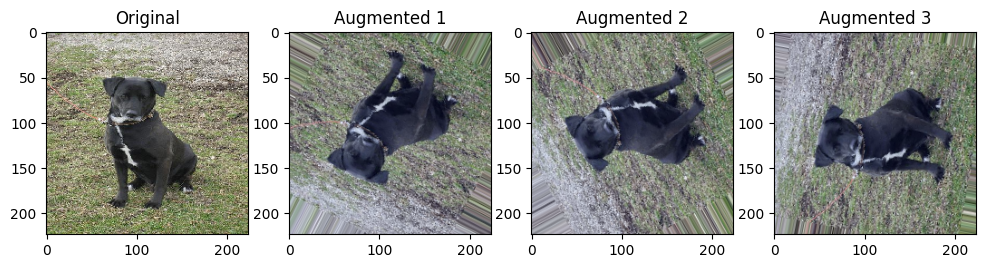

In [23]:
vis_datagen(datagen,2)

In [5]:
#from keras.preprocessing.image import flow_from_directory
from keras.preprocessing.image import ImageDataGenerator
img_size = (224,224)

train_generator = image_dataset_from_directory(train_path,
                                              image_size=img_size,
                                              batch_size=32,
                                              seed=1337)#,
                                              #label_mode = "categorical")
val_generator = image_dataset_from_directory(val_path,
                                             image_size=img_size,
                                             batch_size=32,
                                             seed=1337)#,
                                            #label_mode = "categorical")

x_train, y_train = tuple(zip(*train_generator))
x_val, y_val = tuple(zip(*val_generator))   

datagen = ImageDataGenerator(rescale=1./255,
                             featurewise_center=True, 
                             featurewise_std_normalization=True,
                             vertical_flip=True,
                             rotation_range=90)

datagen.fit(x_train[0]) 
train_generator = datagen.flow_from_directory(train_path,
                                              target_size=img_size,
                                              batch_size=32,
                                              class_mode="categorical")

val_generator = datagen.flow_from_directory(val_path,
                                          target_size=img_size,
                                          batch_size=32,
                                          class_mode='categorical')
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

DefaultMaxPooling = partial(keras.layers.MaxPooling2D, pool_size=(2,2), strides=(2,2))

model2 = keras.models.Sequential([
        DefaultConv2D(filters=64, input_shape=[224,224,3]),
        DefaultConv2D(filters=64),
        DefaultMaxPooling(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        DefaultMaxPooling(),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        DefaultMaxPooling(),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultMaxPooling(),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultMaxPooling(),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(num_classes, activation = 'softmax')
])

Found 15480 files belonging to 120 classes.


2022-09-16 11:00:22.053053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 11:00:22.085839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 11:00:22.085946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 11:00:22.086645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Found 3091 files belonging to 120 classes.
la1
la2
la3
Found 15480 images belonging to 120 classes.
Found 3091 images belonging to 120 classes.
la4


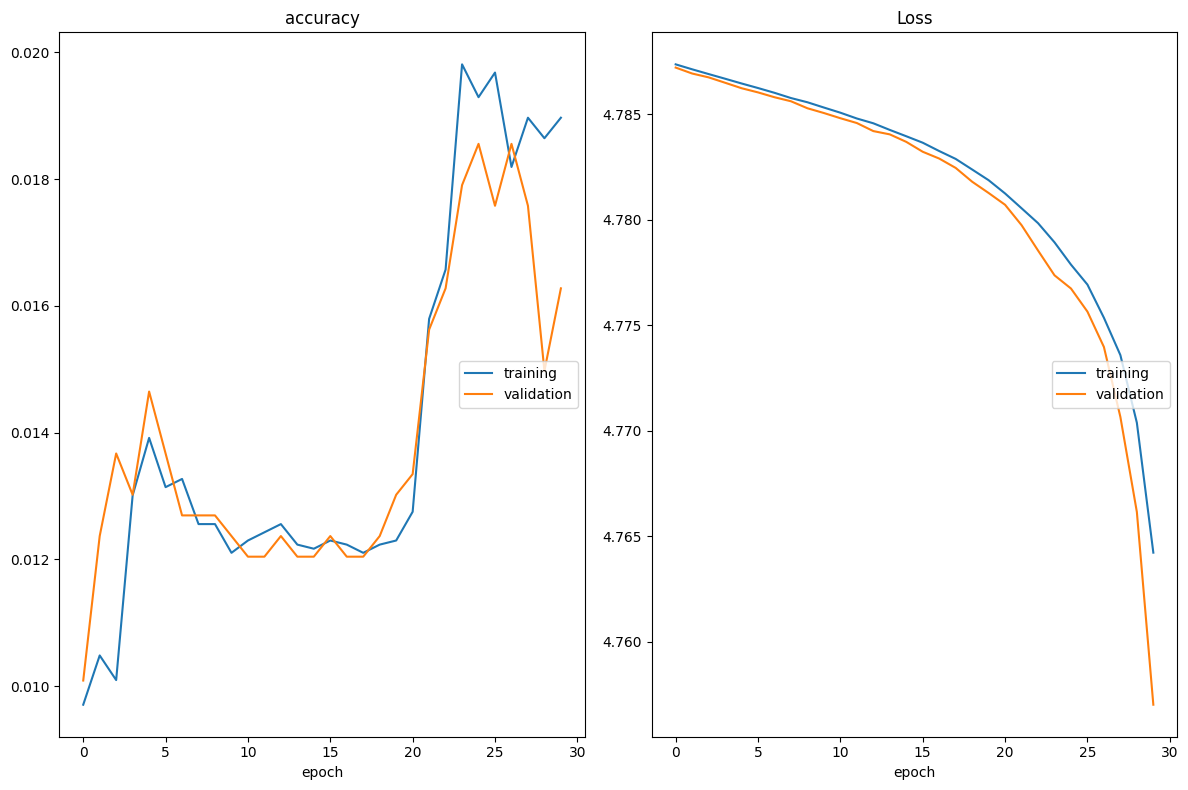

accuracy
	training         	 (min:    0.010, max:    0.020, cur:    0.019)
	validation       	 (min:    0.010, max:    0.019, cur:    0.016)
Loss
	training         	 (min:    4.764, max:    4.787, cur:    4.764)
	validation       	 (min:    4.757, max:    4.787, cur:    4.757)
483/483 [==============================] - 300s 621ms/step - loss: 4.7642 - accuracy: 0.0190 - val_loss: 4.7570 - val_accuracy: 0.0163


In [6]:
models_path = os.path.join(directory, "models2")
os.makedirs(models_path, exist_ok=True)
file_path = models_path + "/my_vgg_model2.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')
plot_loss_cb = PlotLossesKeras()

batch_size = 32
epochs = 30

model2.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"],
              run_eagerly=True)

history = model2.fit(train_generator,
          steps_per_epoch = train_size // batch_size,
          epochs=epochs,
          validation_data=val_generator,
          validation_steps = val_size // batch_size,
          callbacks=[checkpoint_cb, plot_loss_cb])

## II-2 Transfer learning

## VGG16

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False
    
num_classes = 120
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

In [10]:
directory = os.getcwd()
images = os.path.join(directory, "Images")
data = os.path.join(directory, "data")
train_path = os.path.join(data, "train")
val_path = os.path.join(data, "val")
test_path = os.path.join(data, "test")

batch_size = 32

train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


val_generator = val_datagen.flow_from_directory(val_path,
                                          target_size=(224,224),
                                          shuffle=False,
                                          batch_size=batch_size,
                                          class_mode='categorical')

Found 15480 images belonging to 120 classes.
Found 3091 images belonging to 120 classes.


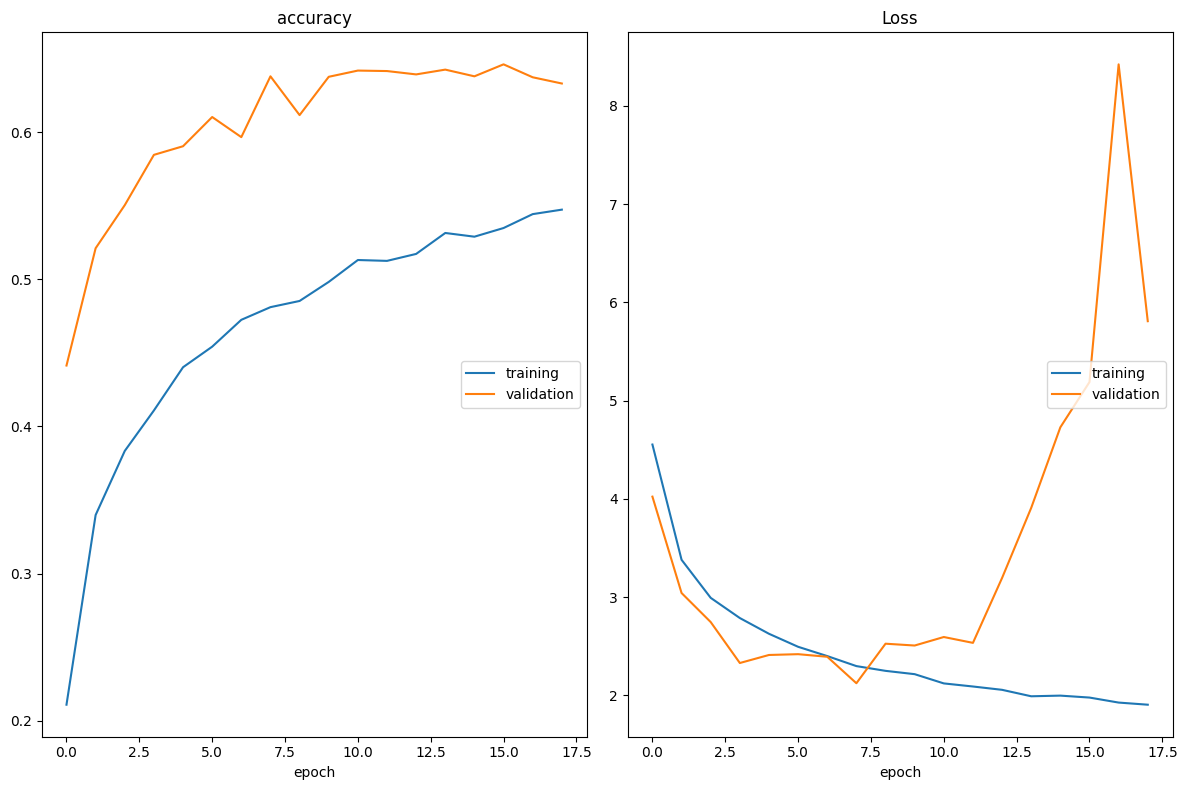

accuracy
	training         	 (min:    0.211, max:    0.547, cur:    0.547)
	validation       	 (min:    0.441, max:    0.646, cur:    0.633)
Loss
	training         	 (min:    1.906, max:    4.553, cur:    1.906)
	validation       	 (min:    2.124, max:    8.422, cur:    5.808)
483/483 [==============================] - 107s 222ms/step - loss: 1.9056 - accuracy: 0.5474 - val_loss: 5.8083 - val_accuracy: 0.6331
Epoch 18: early stopping
CPU times: user 33min 55s, sys: 20.8 s, total: 34min 16s
Wall time: 32min 7s


In [6]:
%%time 
model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop", 
              metrics=["accuracy"])

models_path = os.path.join(directory, "models4")
file_path = models_path + "/transfert_vgg_model4.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
plot_loss_cb = PlotLossesKeras()


epochs = 30

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])

In [12]:
%%time
test_generator = train_datagen.flow_from_directory(test_path,
                                                  shuffle=False,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')
from tensorflow.keras.models import load_model
model = load_model("./models4/transfert_vgg_model4.h5", compile=True)
results = model.evaluate(test_generator, steps=test_size // batch_size)
print(f"test loss, test acc: {results}")

Found 2009 images belonging to 120 classes.
62/62 [==============================] - 11s 167ms/step - loss: 1.7230 - accuracy: 0.5902
test loss, test acc: [1.723006248474121, 0.5902217626571655]
CPU times: user 12 s, sys: 1.02 s, total: 13 s
Wall time: 12.3 s


##### On constate que les résultats du modèle pré-entrainé sont nettement meilleur que le modèl "maison". Le taux d'accuracy du jeu de validation est meilleur que celui du jeu d'entrainement, ce qui laisse penser que l'on peut potentiellement se trouver dans une situation de surapprentissage. On le vérifie sur les données de test

In [15]:
test_generator = train_datagen.flow_from_directory(test_path,
                                                  shuffle=False,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')
from tensorflow.keras.models import load_model
model = load_model("./models4/transfert_vgg_model4.h5", compile=True)
results = model.evaluate(test_generator, steps=test_size // batch_size)
print(f"test loss, test acc: {results}")

Found 2009 images belonging to 120 classes.
62/62 [==============================] - 11s 166ms/step - loss: 1.6407 - accuracy: 0.5877
test loss, test acc: [1.6407238245010376, 0.5877016186714172]


##### L'accuracy du jeu de test se trouve entre les valeurs d'accuracy du jeu d'entrainement et du jeu de validation. On ne se trouve pas totalement dans une situation de surapprentissage. Le moodèl à réussi à apprendre à partir du jeu d'entrainement.
Nous allons maintenant chercher un modèl présentant de meilleur performances que celui-ci.

## ResNet50

In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

base_model = ResNet50(include_top=False,
                  input_shape = (224,224,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

num_classes = 120
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

batch_size = 32

train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(val_path,
                                          target_size=(224,224),
                                          shuffle=False,
                                          batch_size=batch_size,
                                          class_mode='categorical')

Found 15480 images belonging to 120 classes.
Found 3091 images belonging to 120 classes.


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

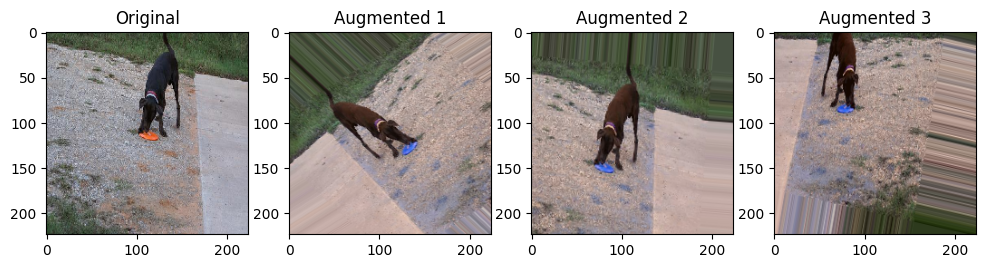

In [12]:
vis_datagen(train_datagen,3)

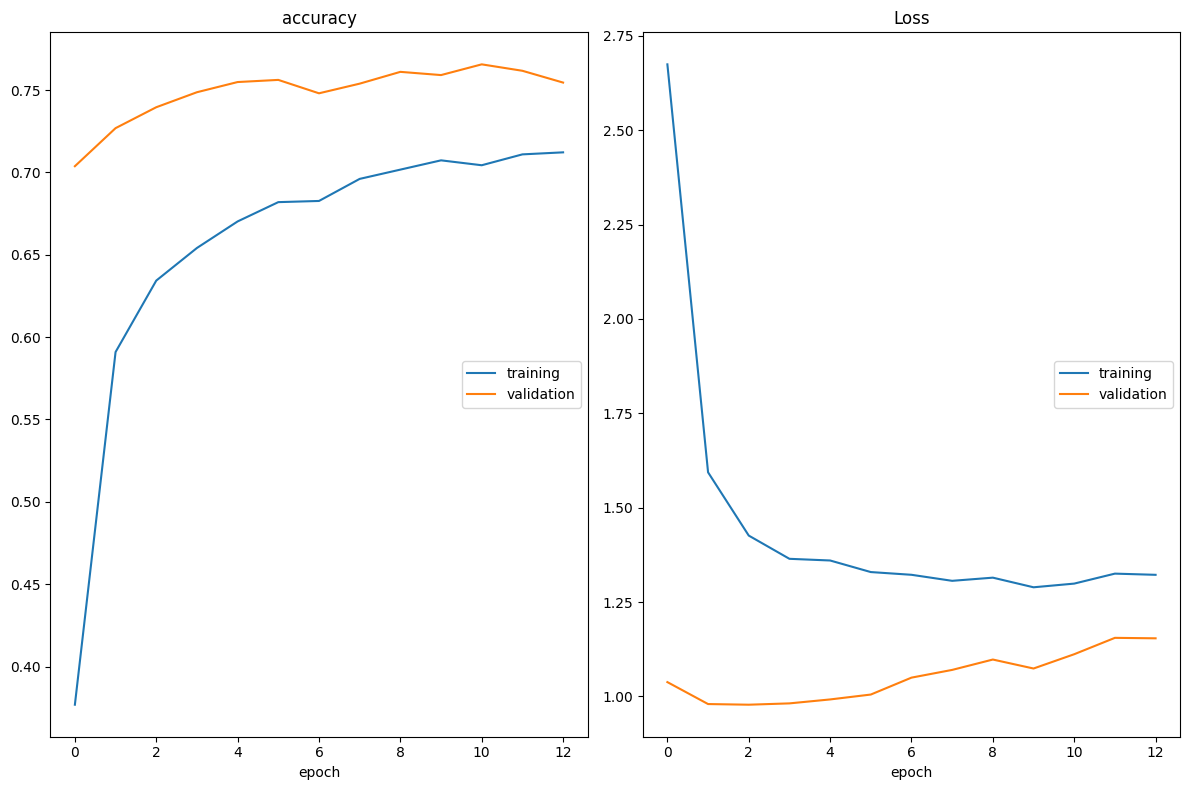

accuracy
	training         	 (min:    0.377, max:    0.712, cur:    0.712)
	validation       	 (min:    0.704, max:    0.766, cur:    0.755)
Loss
	training         	 (min:    1.289, max:    2.674, cur:    1.322)
	validation       	 (min:    0.978, max:    1.155, cur:    1.154)
483/483 [==============================] - 94s 194ms/step - loss: 1.3222 - accuracy: 0.7122 - val_loss: 1.1540 - val_accuracy: 0.7546
Epoch 13: early stopping


In [7]:
model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop", 
              metrics=["accuracy"])

models_path = os.path.join(directory, "models_resnet")
file_path = models_path + "/transfert_resnet50_model.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
plot_loss_cb = PlotLossesKeras()


epochs = 30

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])

In [17]:
test_generator = train_datagen.flow_from_directory(test_path,
                                                  shuffle=False,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')
from tensorflow.keras.models import load_model
model = load_model("./models_resnet/transfert_resnet50_model.h5", compile=True)
results = model.evaluate(test_generator, steps=test_size // batch_size)
print(f"test loss, test acc: {results}")

Found 2009 images belonging to 120 classes.
 2/62 [..............................] - ETA: 5s - loss: 1.8985 - accuracy: 0.6562  

2022-09-15 14:31:16.051446: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-15 14:31:16.051469: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-15 14:31:16.079824: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-15 14:31:16.079843: W tensorflow/core/common_runtime/bfc_allocato

62/62 [==============================] - 11s 159ms/step - loss: 1.3942 - accuracy: 0.7031
test loss, test acc: [1.3942382335662842, 0.703125]


##### On obtient ici de meilleurs résultats avec un accuracy encore une fois compris les valeurs des jeux d'apprentissage et de validation.

## Xception

In [16]:
from tensorflow.keras.applications.xception import Xception, preprocess_input

base_model = Xception(include_top=False,
                  input_shape = (224,224,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

num_classes = 120
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation = 'softmax')(x)

In [17]:
batch_size = 32

train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(val_path,
                                          target_size=(224,224),
                                          shuffle=False,
                                          batch_size=batch_size,
                                          class_mode='categorical')

Found 15480 images belonging to 120 classes.
Found 3091 images belonging to 120 classes.


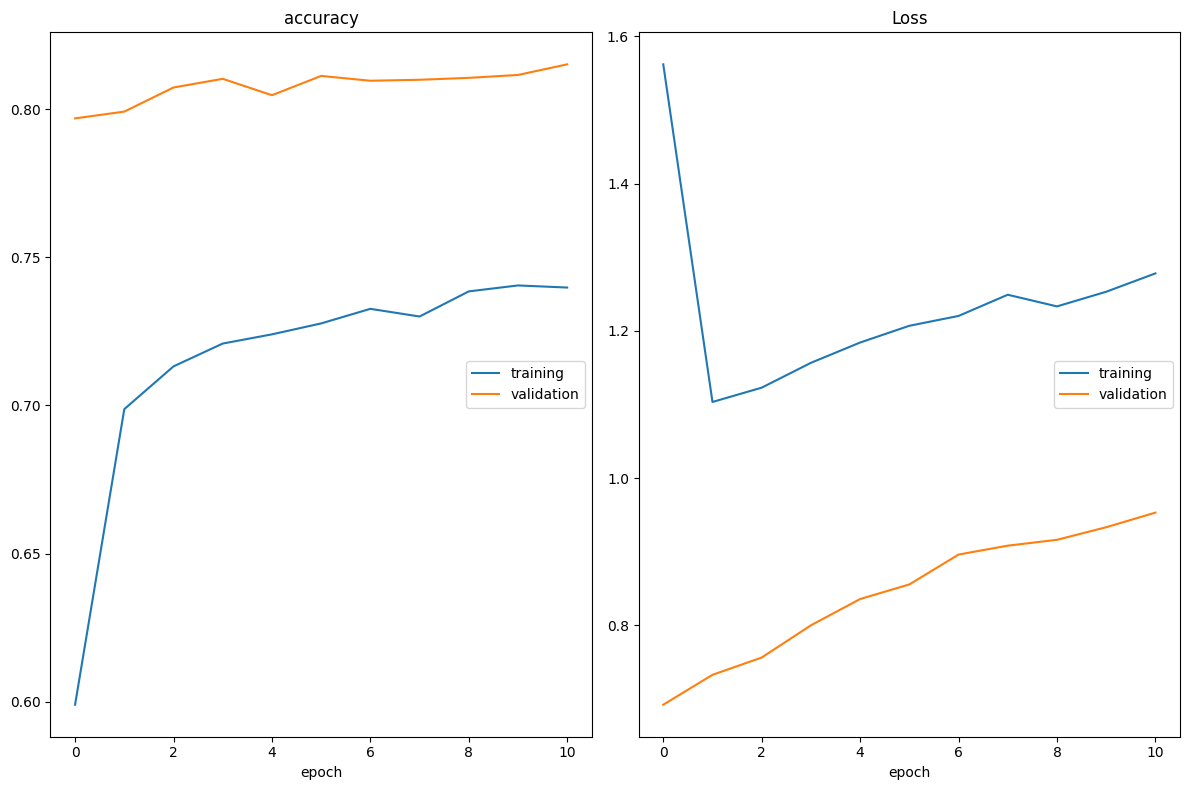

accuracy
	training         	 (min:    0.599, max:    0.740, cur:    0.740)
	validation       	 (min:    0.797, max:    0.815, cur:    0.815)
Loss
	training         	 (min:    1.104, max:    1.562, cur:    1.278)
	validation       	 (min:    0.692, max:    0.953, cur:    0.953)
483/483 [==============================] - 88s 181ms/step - loss: 1.2782 - accuracy: 0.7398 - val_loss: 0.9533 - val_accuracy: 0.8151
Epoch 11: early stopping


In [3]:
model = keras.Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop", 
              metrics=["accuracy"])

models_path = os.path.join(directory, "models_xception")
file_path = models_path + "/transfert_xception_model.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
plot_loss_cb = PlotLossesKeras()


epochs = 30

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])

In [18]:
test_generator = train_datagen.flow_from_directory(test_path,
                                                  shuffle=False,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')
from tensorflow.keras.models import load_model
model = load_model("./models_xception/transfert_xception_model.h5", compile=True)
results = model.evaluate(test_generator, steps=test_size // batch_size)
print(f"test loss, test acc: {results}")

Found 2009 images belonging to 120 classes.
62/62 [==============================] - 11s 164ms/step - loss: 1.4988 - accuracy: 0.7097
test loss, test acc: [1.4988391399383545, 0.7096773982048035]


## Xception - Hyperparamètre modifiés

In [ ]:
from tensorflow.keras.applications.xception import Xception, preprocess_input

base_model = Xception(include_top=False,
                  input_shape = (224,224,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

num_classes = 120
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

batch_size = 16 #MODIFIE

train_datagen = ImageDataGenerator(rotation_range=40, 
                                  width_shift_range=0.3, #MODIFIE
                                  height_shift_range=0.3, #MODIFIE
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input,
                                  featurewise_center=True, 
                                  featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(val_path,
                                          target_size=(224,224),
                                          shuffle=False,
                                          batch_size=batch_size,
                                          class_mode='categorical')

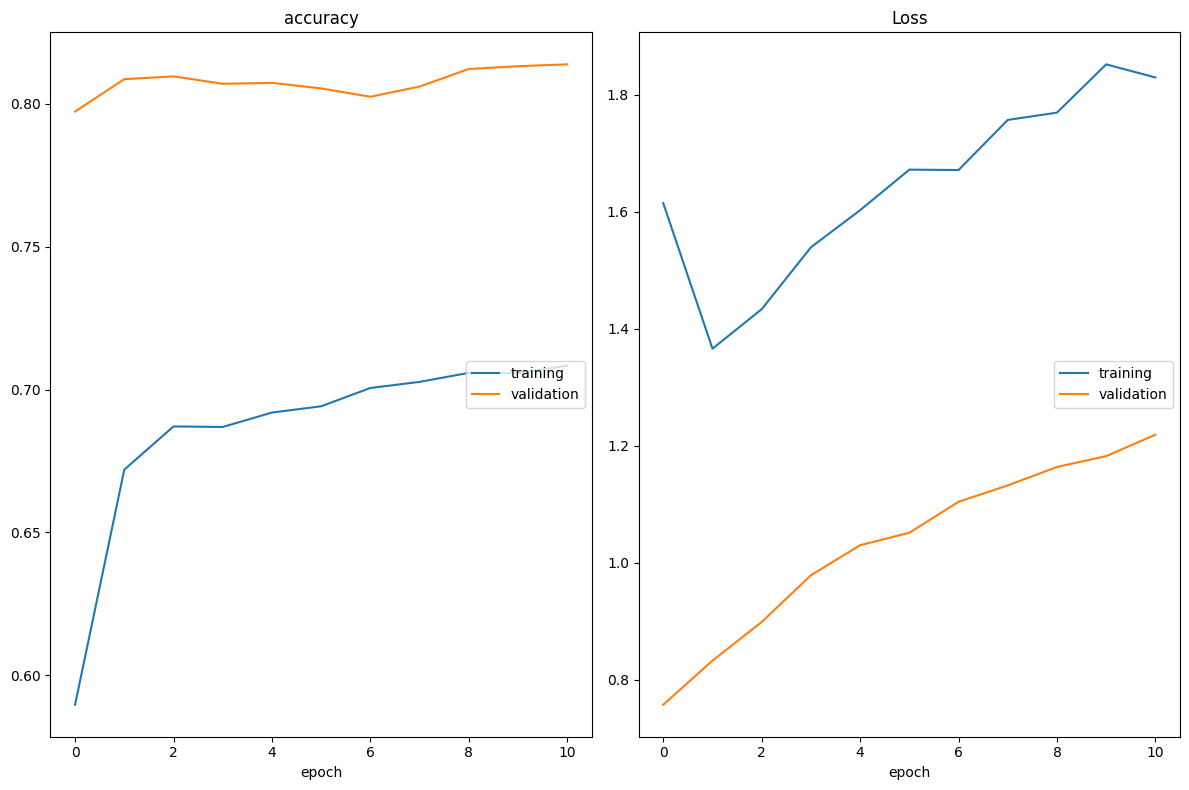

accuracy
	training         	 (min:    0.590, max:    0.708, cur:    0.708)
	validation       	 (min:    0.797, max:    0.814, cur:    0.814)
Loss
	training         	 (min:    1.366, max:    1.852, cur:    1.829)
	validation       	 (min:    0.757, max:    1.219, cur:    1.219)
967/967 [==============================] - 93s 96ms/step - loss: 1.8294 - accuracy: 0.7084 - val_loss: 1.2189 - val_accuracy: 0.8138
Epoch 11: early stopping


In [6]:
model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop", 
              metrics=["accuracy"])

models_path = os.path.join(directory, "models_xception2")
file_path = models_path + "/transfert_xception_model2.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
plot_loss_cb = PlotLossesKeras()

epochs = 20

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])

# EfficientNetV2L

In [27]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L, preprocess_input

base_model = EfficientNetV2L(include_top=False,
                             input_shape = (224,224,3),
                             weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

num_classes = 120
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras

batch_size = 32

train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2, 
                                  height_shift_range=0.2, 
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(val_path,
                                          target_size=(224,224),
                                          shuffle=False,
                                          batch_size=batch_size,
                                          class_mode='categorical')

Found 15480 images belonging to 120 classes.
Found 3091 images belonging to 120 classes.


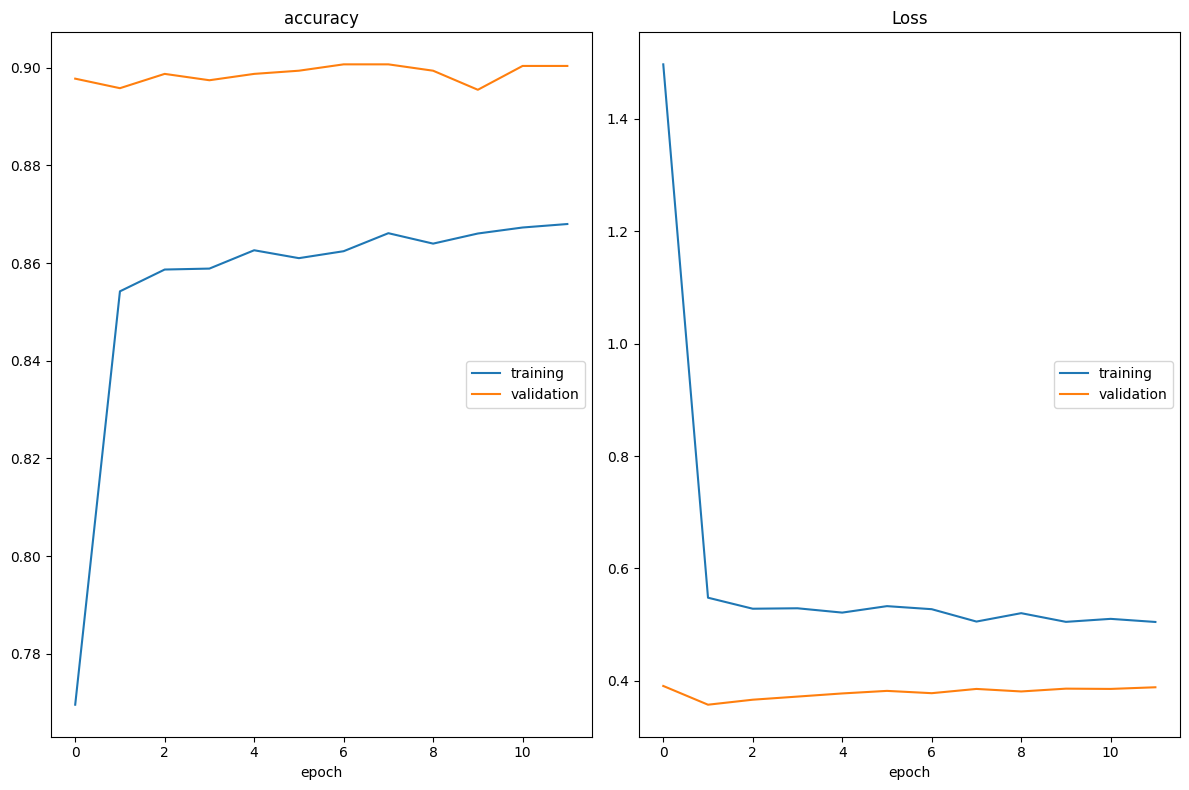

accuracy
	training         	 (min:    0.770, max:    0.868, cur:    0.868)
	validation       	 (min:    0.896, max:    0.901, cur:    0.900)
Loss
	training         	 (min:    0.505, max:    1.497, cur:    0.505)
	validation       	 (min:    0.358, max:    0.391, cur:    0.389)
483/483 [==============================] - 211s 437ms/step - loss: 0.5047 - accuracy: 0.8680 - val_loss: 0.3885 - val_accuracy: 0.9004
Epoch 12: early stopping


In [8]:
model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop", 
              metrics=["accuracy"])

models_path = os.path.join(directory, "models_efficientnetv2l")
file_path = models_path + "/transfert_efficientnetv2l_model.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
plot_loss_cb = PlotLossesKeras()


epochs = 20

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])

## EfficientNetV2L - V2

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L, preprocess_input

base_model = EfficientNetV2L(include_top=False,
                      input_shape = (224,224,3),
                      weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

num_classes = 120
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras

batch_size = 16

train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2, 
                                  height_shift_range=0.2, 
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")


val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


val_generator = val_datagen.flow_from_directory(val_path,
                                          target_size=(224,224),
                                          shuffle=False,
                                          batch_size=batch_size,
                                          class_mode='categorical')

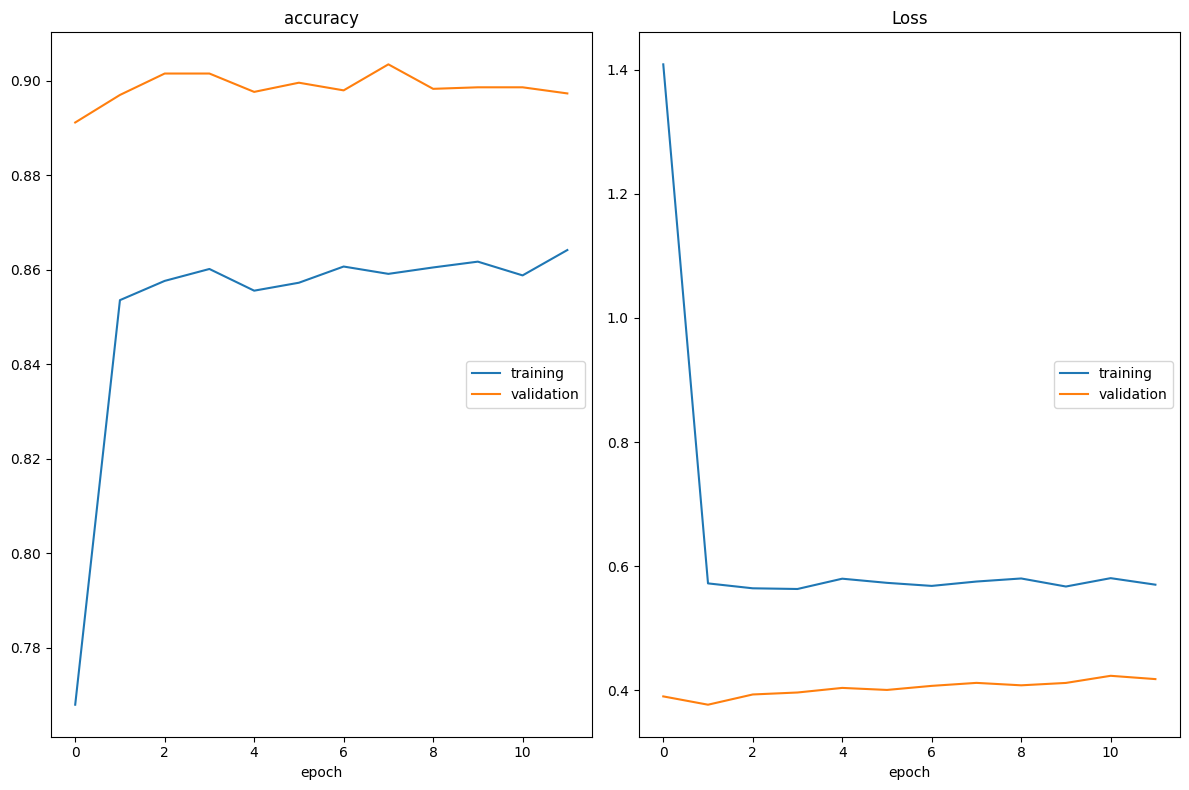

accuracy
	training         	 (min:    0.768, max:    0.864, cur:    0.864)
	validation       	 (min:    0.891, max:    0.903, cur:    0.897)
Loss
	training         	 (min:    0.563, max:    1.408, cur:    0.570)
	validation       	 (min:    0.377, max:    0.423, cur:    0.418)
967/967 [==============================] - 227s 235ms/step - loss: 0.5702 - accuracy: 0.8642 - val_loss: 0.4181 - val_accuracy: 0.8973
Epoch 12: early stopping


In [17]:
model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop", 
              metrics=["accuracy"])

models_path = os.path.join(directory, "models_efficientnetv2l2")
file_path = models_path + "/transfert_efficientnetv2l2_model.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
plot_loss_cb = PlotLossesKeras()


epochs = 20

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])

## InceptionResNetV2

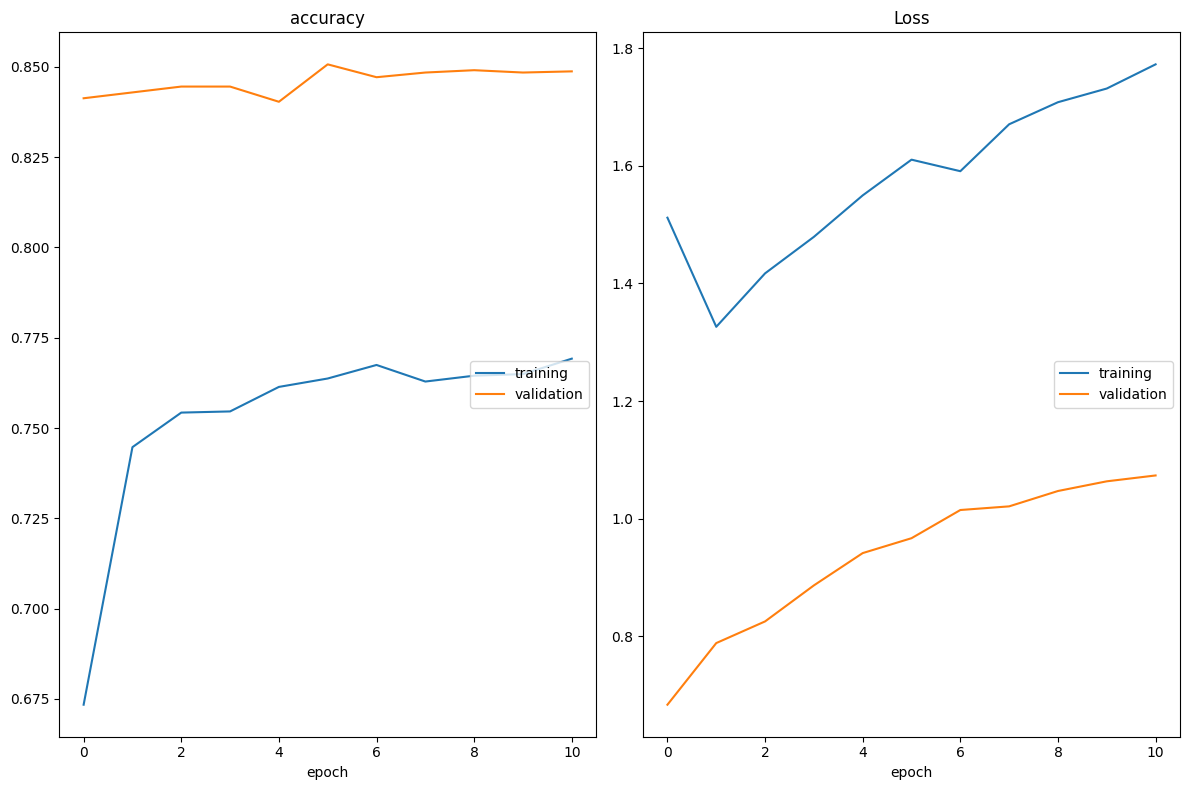

accuracy
	training         	 (min:    0.673, max:    0.769, cur:    0.769)
	validation       	 (min:    0.840, max:    0.851, cur:    0.849)
Loss
	training         	 (min:    1.326, max:    1.773, cur:    1.773)
	validation       	 (min:    0.683, max:    1.073, cur:    1.073)
967/967 [==============================] - 98s 101ms/step - loss: 1.7727 - accuracy: 0.7692 - val_loss: 1.0734 - val_accuracy: 0.8488
Epoch 11: early stopping


In [18]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

base_model = InceptionResNetV2(include_top=False,
                      input_shape = (224,224,3),
                      weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

num_classes = 120
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras


directory = os.getcwd()
images = os.path.join(directory, "Images")
data = os.path.join(directory, "data")
train_path = os.path.join(data, "train")
val_path = os.path.join(data, "val")
test_path = os.path.join(data, "test")

batch_size = 16

train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2, 
                                  height_shift_range=0.2, 
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(val_path,
                                          target_size=(224,224),
                                          shuffle=False,
                                          batch_size=batch_size,
                                          class_mode='categorical')

model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop", 
              metrics=["accuracy"])

models_path = os.path.join(directory, "models_InceptionResNetV2")
file_path = models_path + "/transfert_InceptionResNetV2.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
plot_loss_cb = PlotLossesKeras()

epochs = 20

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])

## NASNetLarge

In [18]:
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input

base_model = NASNetLarge(include_top=False,
                      input_shape = (331,331,3),
                      weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

num_classes = 120
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras

batch_size = 16

train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2, 
                                  height_shift_range=0.2, 
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(331,331),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")


val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


val_generator = val_datagen.flow_from_directory(val_path,
                                          target_size=(331,331),
                                          shuffle=False,
                                          batch_size=batch_size,
                                          class_mode='categorical')

Found 15480 images belonging to 120 classes.
Found 3091 images belonging to 120 classes.


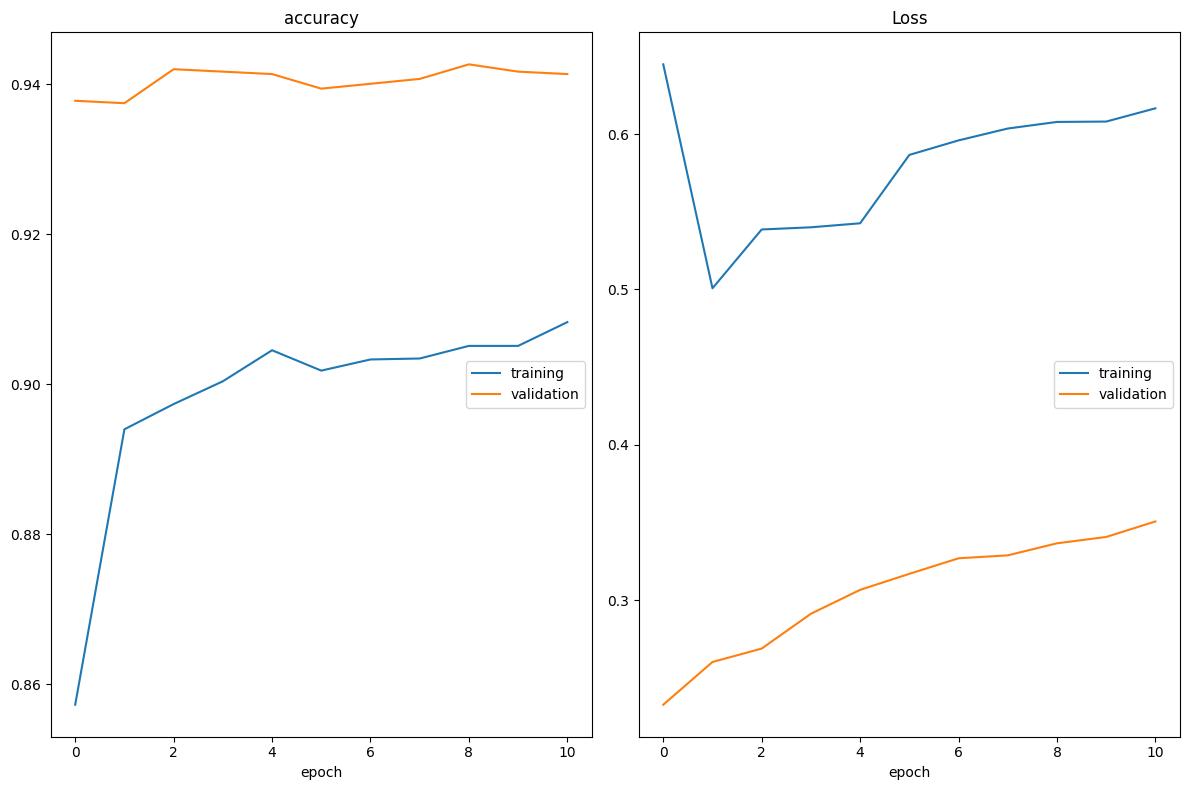

accuracy
	training         	 (min:    0.857, max:    0.908, cur:    0.908)
	validation       	 (min:    0.938, max:    0.943, cur:    0.941)
Loss
	training         	 (min:    0.501, max:    0.645, cur:    0.617)
	validation       	 (min:    0.233, max:    0.351, cur:    0.351)
967/967 [==============================] - 471s 487ms/step - loss: 0.6166 - accuracy: 0.9083 - val_loss: 0.3508 - val_accuracy: 0.9414
Epoch 11: early stopping


In [19]:
model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop", 
              metrics=["accuracy"])

models_path = os.path.join(directory, "models_NASNetLarge")
file_path = models_path + "/transfert_NASNetLarge_model.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
plot_loss_cb = PlotLossesKeras()


epochs = 20

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])

In [19]:
%%time
test_generator = train_datagen.flow_from_directory(test_path,
                                                  shuffle=False,
                                                  target_size=(331,331),
                                                  batch_size=32,
                                                  class_mode='categorical')
from tensorflow.keras.models import load_model
model = load_model("./models_NASNetLarge/transfert_NASNetLarge_model.h5", compile=True)
results = model.evaluate(test_generator, steps=test_size // batch_size)
print(f"test loss, test acc: {results}")

Found 2009 images belonging to 120 classes.
 62/125 [=============>................] - ETA: 44s - loss: 0.6409 - accuracy: 0.8926

2022-09-15 14:39:06.810062: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-15 14:39:06.810090: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


125/125 [==============================] - 50s 364ms/step - loss: 0.6330 - accuracy: 0.8940
test loss, test acc: [0.6329902410507202, 0.8939771056175232]


##### Taux d'accuracy de 89% sur le jeu de données de test. Résultat satisfaisant, le seul problème étant le temps d'éxecution assez long du modèl.

## EfficientNetV2L

In [20]:
%%time
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L, preprocess_input

base_model = EfficientNetV2L(include_top=False,
                             input_shape = (331,331,3),
                             weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

num_classes = 120
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

batch_size = 16

train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2, 
                                  height_shift_range=0.2, 
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(331,331),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


val_generator = val_datagen.flow_from_directory(val_path,
                                          target_size=(331,331),
                                          shuffle=False,
                                          batch_size=batch_size,
                                          class_mode='categorical')

Found 15480 images belonging to 120 classes.
Found 3091 images belonging to 120 classes.
CPU times: user 4.01 s, sys: 311 ms, total: 4.32 s
Wall time: 4.22 s


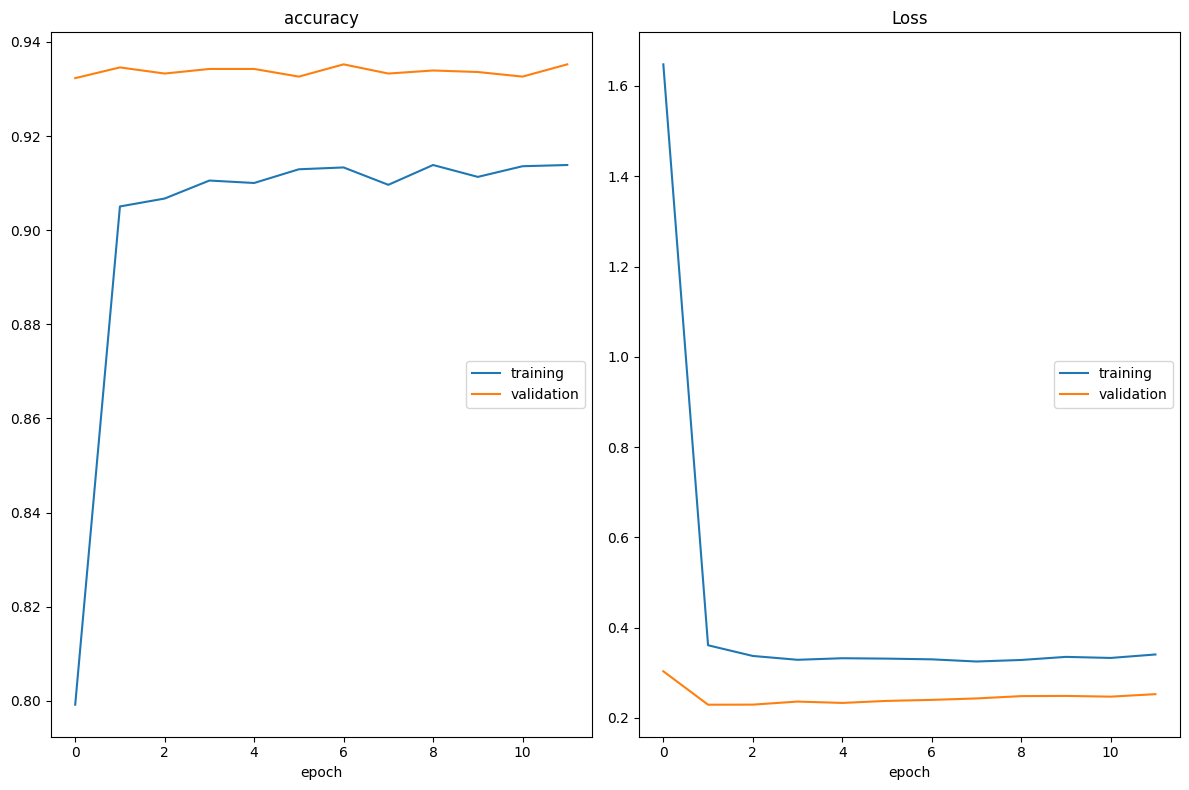

accuracy
	training         	 (min:    0.799, max:    0.914, cur:    0.914)
	validation       	 (min:    0.932, max:    0.935, cur:    0.935)
Loss
	training         	 (min:    0.325, max:    1.648, cur:    0.340)
	validation       	 (min:    0.229, max:    0.303, cur:    0.252)
483/483 [==============================] - 454s 939ms/step - loss: 0.3402 - accuracy: 0.9138 - val_loss: 0.2523 - val_accuracy: 0.9352
Epoch 12: early stopping


In [20]:
model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop", 
              metrics=["accuracy"])

models_path = os.path.join(directory, "models_efficientnetv2laugmentee")
file_path = models_path + "/transfert_efficientnetv2l_modelaugmentee.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
plot_loss_cb = PlotLossesKeras()


epochs = 20

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])

##### On constate qu'augmenter la taille des images, et donc la précision de celle ci augmente le temps d'apprentissage mais permet égalemenet de gagner des points d'accuracy.
Testons ce dernier modèle qui performe mieux que tous les autres (sauf le NasNetLarge) sur les données d'entrainement et de validations, sur nos données de test :

In [22]:
%%time
test_generator = train_datagen.flow_from_directory(test_path,
                                                  shuffle=False,
                                                  target_size=(331,331),
                                                  batch_size=32,
                                                  class_mode='categorical')
from tensorflow.keras.models import load_model
model = load_model("./models_efficientnetv2laugmentee/transfert_efficientnetv2l_modelaugmentee.h5", compile=True)
results = model.evaluate(test_generator, steps=test_size // batch_size)
print(f"test loss, test acc: {results}")

Found 2009 images belonging to 120 classes.
125/125 [==============================] - 53s 393ms/step - loss: 0.3105 - accuracy: 0.9204
test loss, test acc: [0.31046923995018005, 0.9203583598136902]
CPU times: user 46.1 s, sys: 11.8 s, total: 58 s
Wall time: 57.4 s


In [22]:
import pickle
class_names = []
for breed in sorted(os.listdir(images)):
    splitted_breed = breed.split('-')
    if len(splitted_breed) > 2:
        class_names.append('-'.join(splitted_breed[1:]))
    else:
        class_names.append(splitted_breed[1])
models_path = os.path.join(directory, "models_efficientnetv2laugmentee")
filename = models_path + '/class_names.save'
pickle.dump(class_names, open(filename, 'wb'))

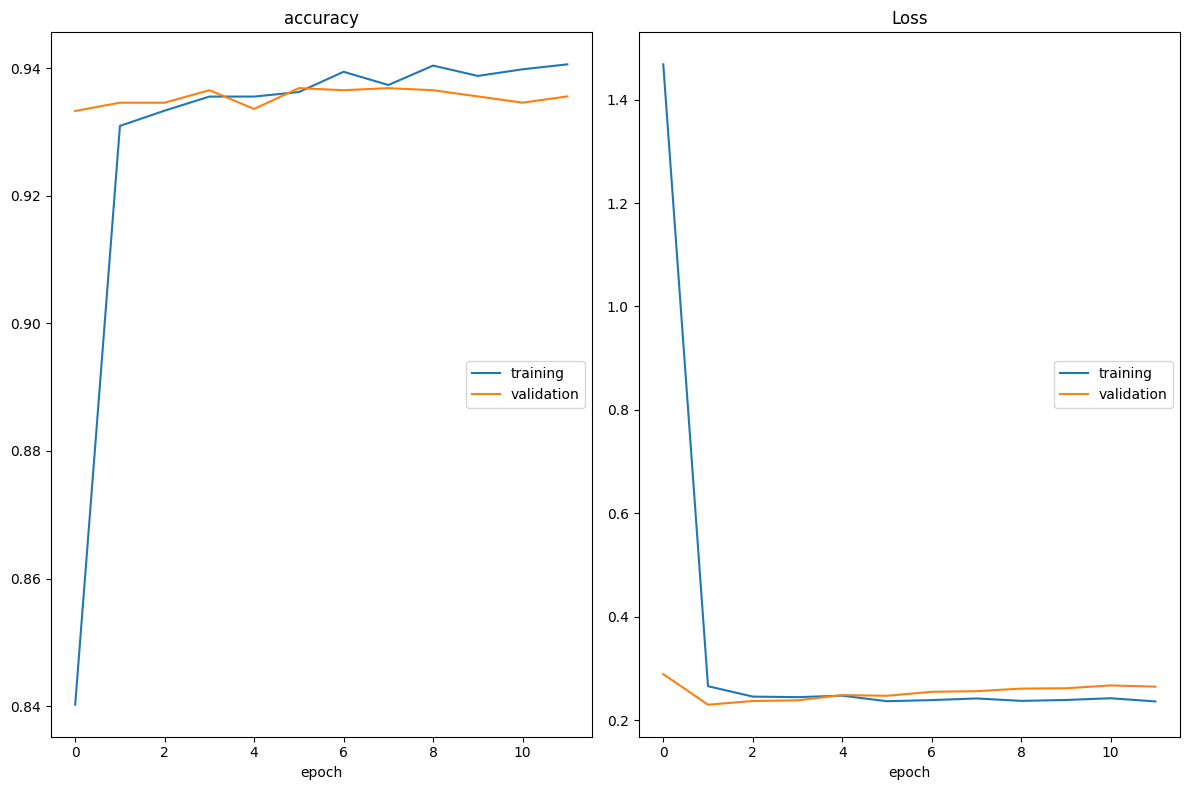

accuracy
	training         	 (min:    0.840, max:    0.941, cur:    0.941)
	validation       	 (min:    0.933, max:    0.937, cur:    0.936)
Loss
	training         	 (min:    0.236, max:    1.468, cur:    0.236)
	validation       	 (min:    0.230, max:    0.289, cur:    0.265)
483/483 [==============================] - 456s 945ms/step - loss: 0.2362 - accuracy: 0.9406 - val_loss: 0.2648 - val_accuracy: 0.9355
Epoch 12: early stopping
CPU times: user 41min 27s, sys: 24min 21s, total: 1h 5min 49s
Wall time: 1h 31min 34s


In [6]:
%%time
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L, preprocess_input

base_model = EfficientNetV2L(include_top=False,
                             input_shape = (331,331,3),
                             weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

num_classes = 120
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

batch_size = 32

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(331,331),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


val_generator = val_datagen.flow_from_directory(val_path,
                                          target_size=(331,331),
                                          shuffle=False,
                                          batch_size=batch_size,
                                          class_mode='categorical')
model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop", 
              metrics=["accuracy"])

models_path = os.path.join(directory, "models_efficientnetv2laugmentee2")
file_path = models_path + "/transfert_efficientnetv2l_modelaugmentee2.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
plot_loss_cb = PlotLossesKeras()


epochs = 20

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])

In [7]:
%%time
test_generator = train_datagen.flow_from_directory(test_path,
                                                  shuffle=False,
                                                  target_size=(331,331),
                                                  batch_size=32,
                                                  class_mode='categorical')
from tensorflow.keras.models import load_model
model = load_model("./models_efficientnetv2laugmentee2/transfert_efficientnetv2l_modelaugmentee2.h5", compile=True)
results = model.evaluate(test_generator, steps=test_size // batch_size)
print(f"test loss, test acc: {results}")

Found 2009 images belonging to 120 classes.
62/62 [==============================] - 50s 763ms/step - loss: 0.2572 - accuracy: 0.9345
test loss, test acc: [0.25717803835868835, 0.9344757795333862]
CPU times: user 25.9 s, sys: 11.1 s, total: 37.1 s
Wall time: 54.2 s


#### Ce modèl apprend mieux que le NasNetLarge et obtient un taux d'accuracy meilleur sur les données de test. Il est de plus plus rapide sur le temps d'éxecution. Nous sélectionnons donc ce modèl comme modèl final.

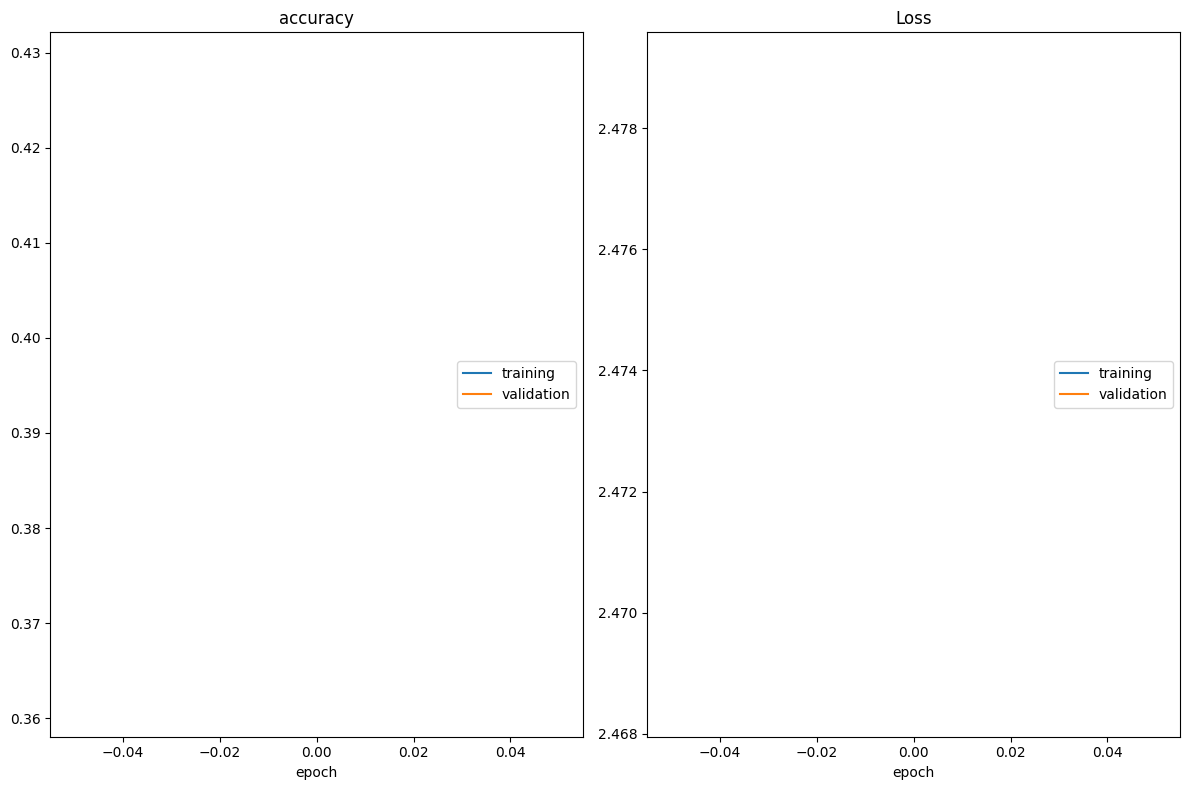

accuracy
	training         	 (min:    0.361, max:    0.361, cur:    0.361)
	validation       	 (min:    0.429, max:    0.429, cur:    0.429)
Loss
	training         	 (min:    2.468, max:    2.468, cur:    2.468)
	validation       	 (min:    2.479, max:    2.479, cur:    2.479)
967/967 [==============================] - 215s 219ms/step - loss: 2.4685 - accuracy: 0.3614 - val_loss: 2.4791 - val_accuracy: 0.4288
Epoch 2/20
920/967 [===========================>..] - ETA: 9s - loss: 1.5462 - accuracy: 0.5576 

In [ ]:
from tensorflow.keras.applications.xception import Xception, preprocess_input

base_model = Xception(include_top=False,
                  input_shape = (224,224,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = True

num_classes = 120
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dropout(0.2)(x)
predictions = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

batch_size = 16

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(val_path,
                                          target_size=(224,224),
                                          shuffle=False,
                                          batch_size=batch_size,
                                          class_mode='categorical')
model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop", 
              metrics=["accuracy"])

models_path = os.path.join(directory, "models_xception3")
file_path = models_path + "/transfert_xception_model3.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
plot_loss_cb = PlotLossesKeras()

epochs = 20

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])